# Krypton waveform NB

- First day of stable data taking for Run III
- Fresh source of Krypton. Suspect intensity is high, perhaps originating too much scintillation.

## Imports

In [1]:
import os
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

2018-03-03 08:53:49


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [3]:
from invisible_cities.database import load_db

import invisible_cities.sierpe.blr as blr

import invisible_cities.reco.tbl_functions as tbl
import invisible_cities.reco.peak_functions as pkf
import invisible_cities.reco.calib_sensors_functions as csf
from   invisible_cities.reco.xy_algorithms      import corona

from   invisible_cities.evm.ic_containers  import S12Params 
from   invisible_cities.evm.ic_containers  import CalibVectors
from   invisible_cities.evm.ic_containers  import DeconvParams
from   invisible_cities.evm.ic_containers  import ThresholdParams

from   invisible_cities.core.system_of_units_c import units
from   invisible_cities.core.core_functions import loc_elem_1d
from   invisible_cities.types.ic_types import minmax
import invisible_cities.icaro.mpl_functions as mpl
import invisible_cities.icaro.signal_functions_mpl as sf
from invisible_cities.icaro.pmaps_mpl import plot_s12
from invisible_cities.sierpe                 import blr

In [4]:
from invisible_cities.reco.dst_functions  import load_dst

In [5]:
from invisible_cities.evm .pmaps             import S1
from invisible_cities.evm .pmaps             import S2

In [6]:
from typing      import NamedTuple

## NB functions

In [7]:
def plot_S12(s12s):
    plt.grid(True)
    plt.xlabel(r't (ns)')
    plt.ylabel(r'q (pes)')
    for s12 in s12s:
        plt.plot(s12.times, s12.pmts.waveform(-1))

In [8]:
def plot_pmt_signals_vs_time_mus(pmt_signals,
                                 pmt_active,
                                 t_min      =    0,
                                 t_max      = 1200,
                                 signal_min =    0,
                                 signal_max =  200,
                                 figsize=(12,12)):
    """Plot PMT signals versus time in mus  and return figure."""

    tstep = 25
    PMTWL = pmt_signals[0].shape[0]
    signal_t = np.arange(0., PMTWL * tstep, tstep)/units.mus
    plt.figure(figsize=figsize)
   
   
    plt.ylabel(r'q (pes/adc)')
    for j, i in enumerate(pmt_active):
        plt.grid(True)
        ax1 = plt.subplot(3, 4, j+1)
        ax1.set_xlim([t_min, t_max])
        ax1.set_ylim([signal_min, signal_max])
        plt.plot(signal_t, pmt_signals[i])
        plt.xlabel(r't (mus)')


In [9]:
def plot_pmt_waveforms(pmtwfdf, first=0, last=50000, figsize=(10,10)):
    """plot PMT wf and return figure"""
    plt.figure(figsize=figsize)
    for i in range(len(pmtwfdf)):
        ax = plt.subplot(3, 4, i+1)
        plt.xlabel(r't (mus)')
        plt.plot(pmtwfdf[i][first:last])


In [275]:

def pmt_and_sipm(cwf_sum, sipm_cal, t_min, t_max, zoom=False):
    
    sipm_sums_w = np.sum(sipm_cal[:, t_min:t_max], axis=1)
    sipm_sums = np.sum(sipm_cal, axis=0)
    
    t = np.arange(len(cwf_sum)) / 40
    plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(t, cwf_sum)
    plt.xlim(t_min , t_max )

    plt.subplot(2, 1, 2)
    plt.plot(sipm_sums)
    plt.xlim(t_min, t_max)

    plt.figure()
    sipms_ = sipm_sums_w > 0 
    x = xs[sipms_]
    y = ys[sipms_]
    q = sipm_sums_w[sipms_]
    print(np.argwhere(sipms_))
    plt.scatter(x, y, s=10, c=q, cmap="jet")
    
    if not zoom:
        plt.xlim(-200, 200)
        plt.ylim(-200, 200)
    plt.colorbar()

In [10]:
def display_s12s(s12s):
    for s12 in s12s:
        print('energy = {} pes charge = {} pes time = {} mus width = {} ns'.format(
        s12.total_energy, s12.total_charge, s12.time_at_max_energy/units.mus, s12.width))

In [13]:
def plot_sipm_signals_vs_time_mus(sipm_signals,
                                  sipm_min      =    0,
                                  sipm_max      = 2000,
                                 figsize=(6,6)):
    """Plot PMT signals versus time in mus  and return figure."""


    plt.figure(figsize=figsize)   
    plt.ylabel(r'q (pes/adc)')
    plt.xlabel(r'sipm number ')
    ax = plt.subplot()
    ax.set_xlim([sipm_min, min(sipm_max, len(sipm_signals))])
    plt.grid(True)
    plt.plot(sipm_signals)
       


In [14]:
def sort_s12s(s12s):
    return sorted(s12s, key= lambda s12 : s12.total_energy, reverse=True)

In [15]:
def kr_dst(s1s, s2s, xs, ys):
    s1 = sort_s12s(s1s)[0]
    s2 = sort_s12s(s2s)[0]
    c = compute_xy_peak_position(s2.sipms, xs, ys)
    
    return KrDst(es1 = s1.total_energy, ws1=s1.width, 
                 es2 =s2.total_energy,  ws2=s1.width, qs2=s2.total_charge, 
                 dt = (s2.time_at_max_energy - s1.time_at_max_energy) / units.mus,
                 c = c)
    

In [16]:
class Cluster(NamedTuple):
    Q     : float
    x     : float 
    y     : float
    nsipm : int

In [17]:
class KrDst(NamedTuple):
    es1  : float
    ws1  : float
    es2  : float
    ws2  : float
    qs2  : float
    dt   : float 
    c    : Cluster


In [18]:
def compute_xy_peak_position(sr, xs, ys):
        """
        Computes position using the integral of the charge
        in each SiPM. Config parameters set equal to the standard kDST values.
        """
        IDs = sr.ids
        Qs = sr.sum_over_times
        xs, ys   = xs[IDs], ys[IDs]
        cls      = corona(np.stack((xs, ys), axis=1), Qs,
                      Qthr           =  1.,
                      Qlm            =  0.,
                      lm_radius      =  -1.,
                      new_lm_radius  =  -1.,
                      msipm          =  1)
        c = cls[0]
        return Cluster(Q=c.Q, x=c._xy.x, y=c._xy.y, nsipm=c.nsipm)


In [19]:
KR = []

## Data base

In [20]:
run_number = 5200
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values
pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist()

In [21]:
channel_id = DataPMT.ChannelID.values
coeff_blr = abs(DataPMT.coeff_blr.values)
coeff_c = abs(DataPMT.coeff_c .values)
adc_to_pes = abs(DataPMT.adc_to_pes.values)
adc_to_pes_sipm = abs(DataSiPM.adc_to_pes.values)

In [22]:
DataPMT

,SensorID,ChannelID,PmtID,Active,X,Y,coeff_blr,coeff_c,adc_to_pes,noise_rms,Sigma
0,0,0,PMT1,1,-23.9414,65.7785,0.000530,4.250400e-07,27.346,0.77,11.551
1,1,12,PMT3,1,-44.9951,-53.6231,0.000533,3.599900e-07,28.257,0.00,12.848
2,2,1,PMT2,1,68.9365,-12.1554,0.000530,5.525500e-07,29.983,0.81,12.072
3,3,13,PMT4,1,0.0000,185.0000,0.000526,3.563900e-07,30.131,0.00,12.006
4,4,19,PMTC,1,-118.9160,141.7180,0.000520,3.804100e-07,36.064,0.75,13.448
5,5,18,PMTB,1,-182.1890,32.1249,0.000529,5.704900e-07,26.945,0.75,9.687
6,6,7,PMTA,1,-160.2150,-92.5000,0.000518,5.597400e-07,31.032,0.00,11.675
7,7,6,PMT9,1,-63.2737,-173.8430,0.000528,5.918400e-07,40.055,0.00,15.462
8,8,2,PMT8,1,63.2737,-173.8430,0.000525,4.849600e-07,28.566,0.00,11.466
9,9,16,PMT7,1,160.2150,-92.5000,0.000527,4.763500e-07,0.000,0.00,0.000


In [23]:
channel_id

array([ 0, 12,  1, 13, 19, 18,  7,  6,  2, 16,  5,  4])

In [28]:
sipm_adc_to_pes = DataSiPM.adc_to_pes.values

In [29]:
sipm_adc_to_pes[181] = 0

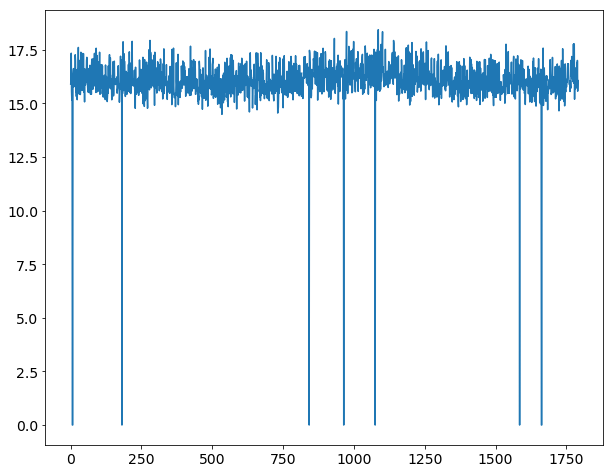

In [30]:
plt.plot(sipm_adc_to_pes)

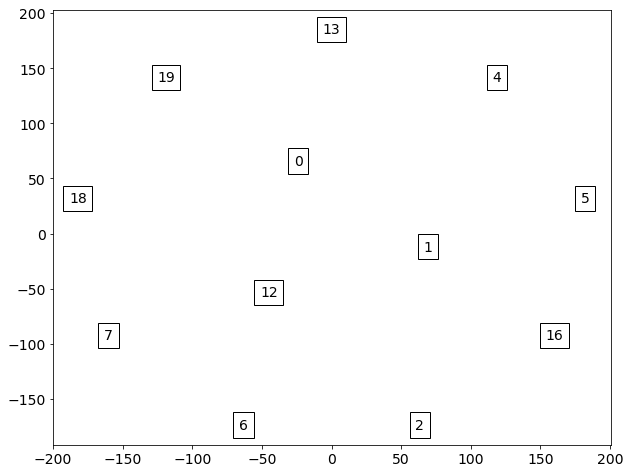

In [31]:
mpl.draw_pmt_map(run_number)

In [32]:
adc_to_pes

array([ 27.346,  28.257,  29.983,  30.131,  36.064,  26.945,  31.032,
        40.055,  28.566,   0.   ,  26.082,  27.499])

In [33]:
adc_to_pes[9] = 25

In [34]:
adc_to_pes

array([ 27.346,  28.257,  29.983,  30.131,  36.064,  26.945,  31.032,
        40.055,  28.566,  25.   ,  26.082,  27.499])

## Input file

In [35]:
filename = '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5200_1245_waveforms.h5'
input_files = [filename]
h5rwf = tb.open_file(filename, "r") 

In [36]:
pmtrwf = h5rwf.root.RD.pmtrwf
sipmrwf = h5rwf.root.RD.sipmrwf
NEVT, NPMT, PMTWL = pmtrwf.shape
_, NSIPM, SIPMWL = sipmrwf.shape

In [37]:
NEVT, NPMT, PMTWL = pmtrwf.shape

In [38]:
print("""
        Number of events in file = {}
        Number of PMTs = {}
        PMTWL = {}
        Number of SiPMs = {}
        SiPMWL = {}
      """.format(NEVT, NPMT, PMTWL, NSIPM, SIPMWL))


        Number of events in file = 164
        Number of PMTs = 12
        PMTWL = 52000
        Number of SiPMs = 1792
        SiPMWL = 1300
      


## S1 and S2 parameters

In [39]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)

In [40]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 800 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)

## Events

### Event

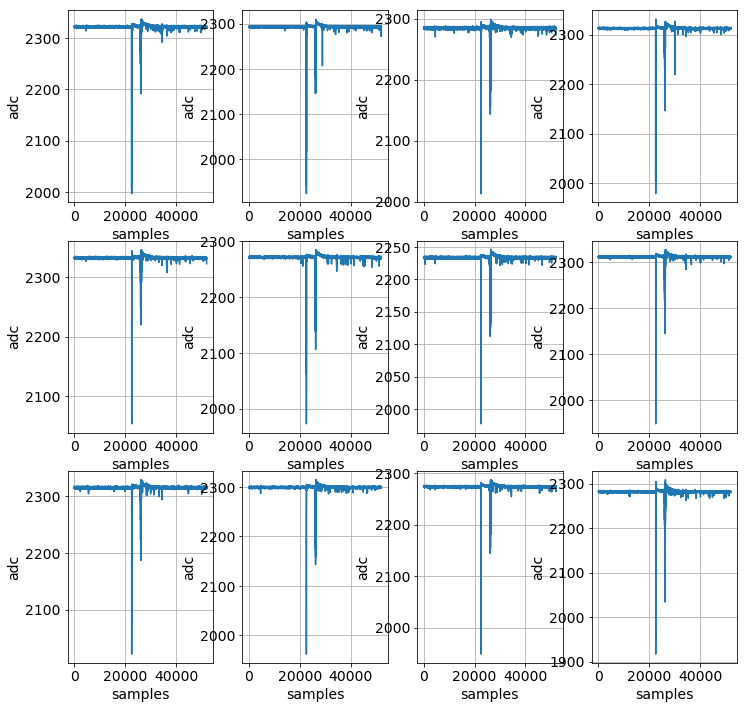

In [276]:
event=1
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

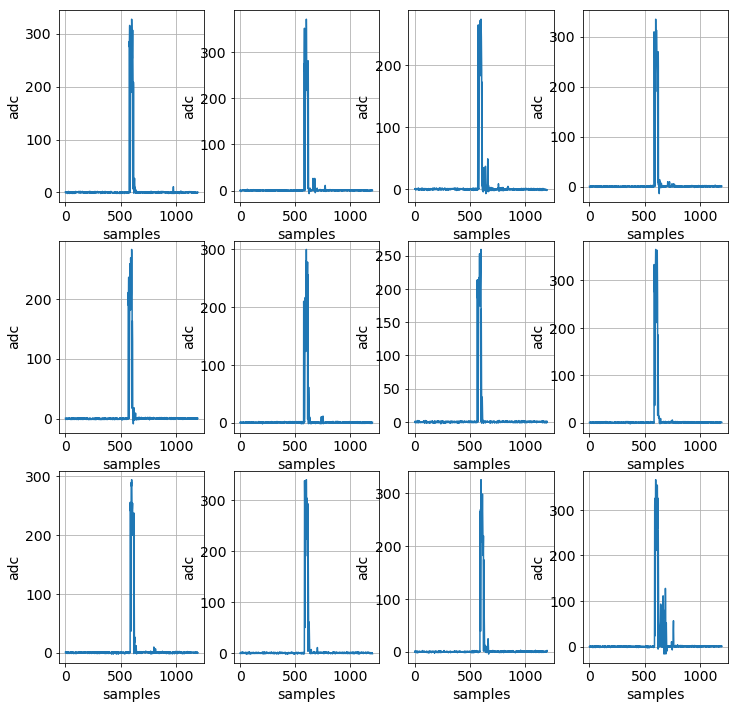

In [277]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

sf.plot_pmt_waveforms(CWF, zoom=True, window_size=600, figsize=(12,12))

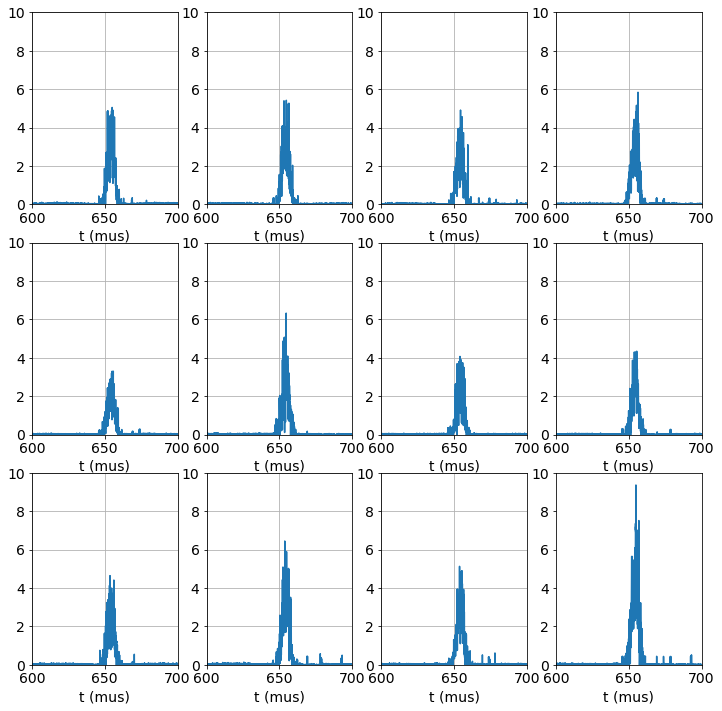

In [278]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)
plot_pmt_signals_vs_time_mus(ccwfs,
                                pmt_active,
                                t_min      =    600,
                                t_max      = 700,
                                signal_min =    0,
                                signal_max =  10,
                                 figsize=(12,12))

- Calibrated sum

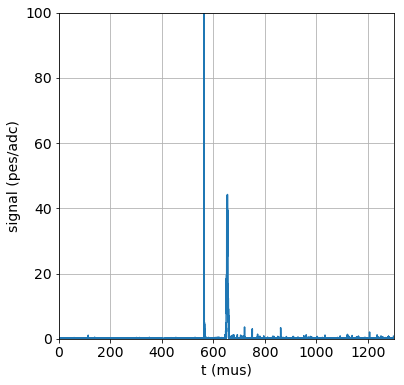

In [279]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

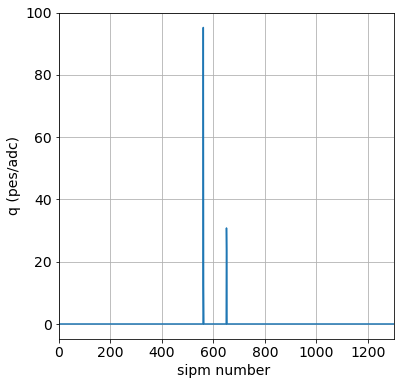

In [280]:
thr = 10
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=thr,
                          bls_mode=csf.BlsMode.mode)
sipm_sums = np.sum(np.where(sipm_cal > thr, sipm_cal, 0), axis=0)
plot_sipm_signals_vs_time_mus(sipm_sums)

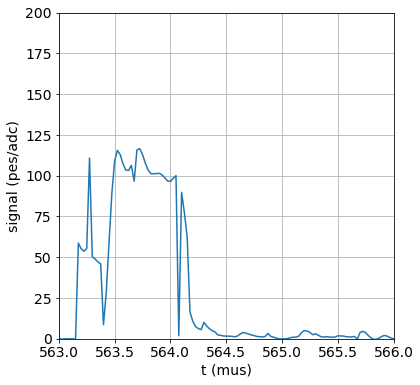

In [281]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =563,
                            t_max      = 566,
                            signal_min =    0,
                            signal_max =  200,
                            figsize=(6,6))

[[609]
 [610]
 [612]
 [615]
 [988]]


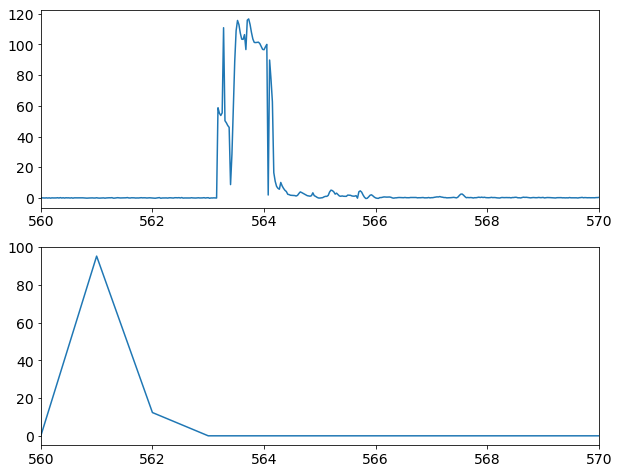

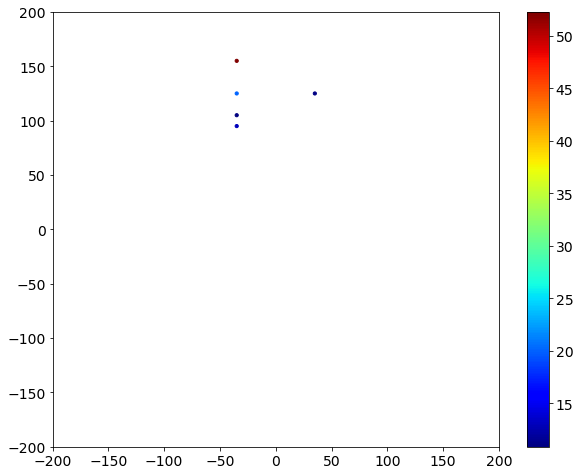

In [282]:
pmt_and_sipm(cwf_sum, sipm_cal, t_min=560, t_max=570)

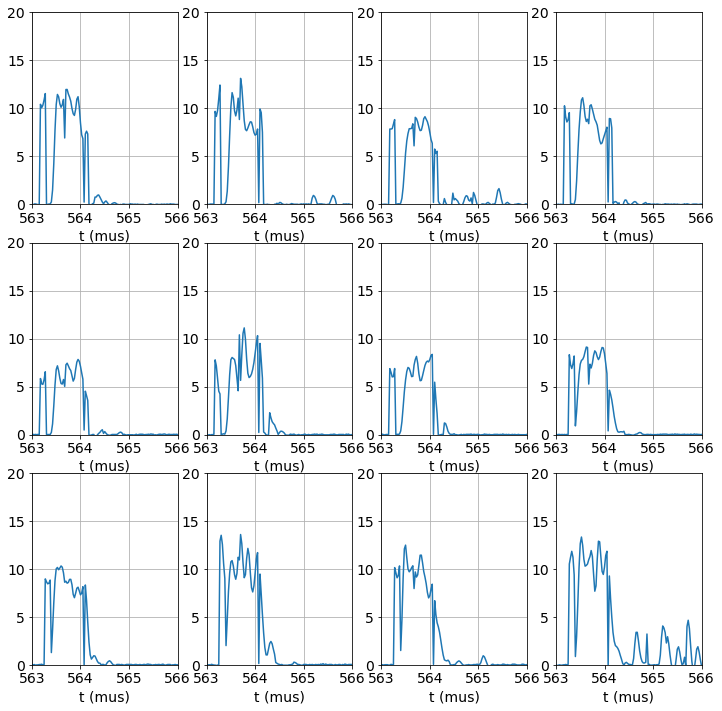

In [209]:
plot_pmt_signals_vs_time_mus(ccwfs,
                             pmt_active,
                            t_min      =563,
                            t_max      = 566,
                            signal_min =    0,
                            signal_max =  20,
                            figsize=(12,12))

In [207]:
s2params = S12Params(time = minmax(min    = 563 * units.mus,
                                   max    = 566 * units.mus),
                           stride = 40,
                           length = minmax(min = 4, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
 ---------------------
 S2 instance
 ---------------------
 Number of samples: 3
 Times: [ 563.6282805   564.13154961  565.46095752] µs
 Time @ max energy: 563.628280497235
 Width: 1.8326770274760202 µs
 Height: 2823.3458671127532 pes
 Energy: 3538.9146008861294 pes
 Charge: 0.0 pes
 RMS: 0.305587494367904 µs]

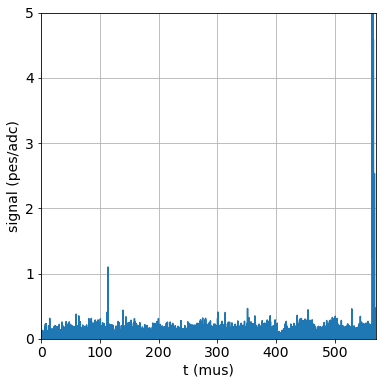

In [58]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 570,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

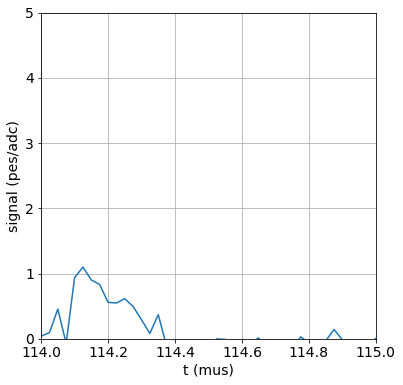

In [63]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =114,
                            t_max      = 115,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

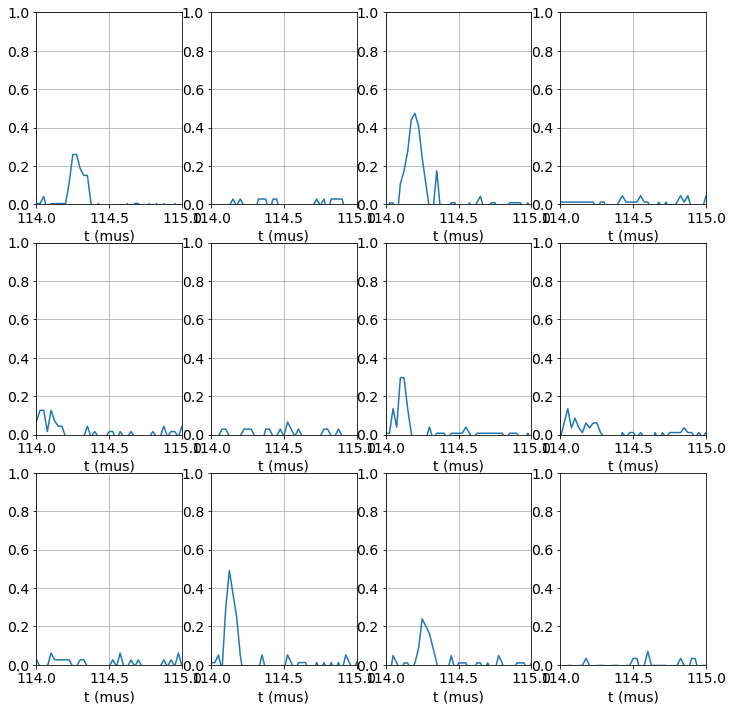

In [175]:
plot_pmt_signals_vs_time_mus(ccwfs,
                             pmt_active,
                            t_min      =114,
                            t_max      = 115,
                            signal_min =    0,
                            signal_max =  1,
                            figsize=(12,12))

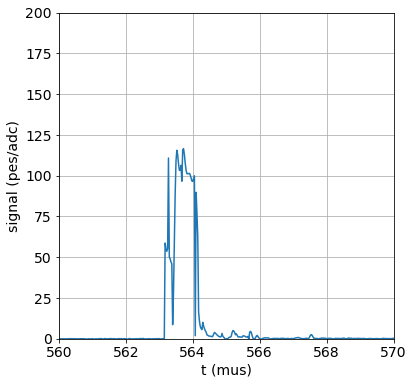

In [176]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =560,
                            t_max      = 570,
                            signal_min =    0,
                            signal_max =  200,
                            figsize=(6,6))

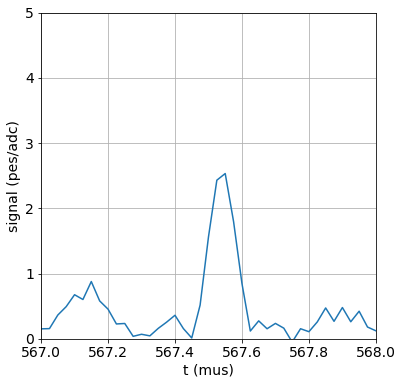

In [61]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =567,
                            t_max      = 568,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

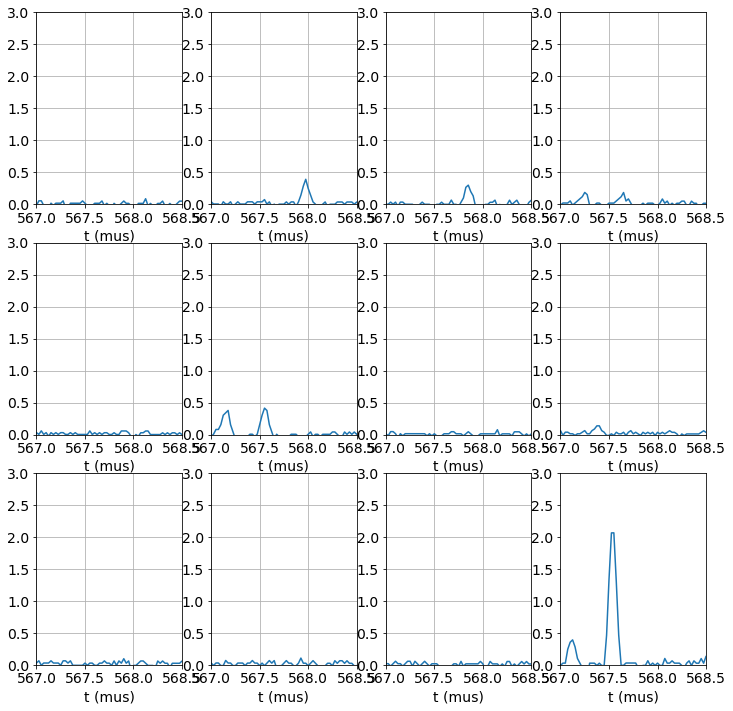

In [182]:
plot_pmt_signals_vs_time_mus(ccwfs,
                             pmt_active,
                            t_min      =567,
                            t_max      = 568.5,
                            signal_min =    0,
                            signal_max =  3,
                            figsize=(12,12))

#### Search for S1 and S2a

In [178]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 20),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 7
 Times: [ 114.1    114.125  114.15   114.175  114.2    114.225  114.25 ] µs
 Time @ max energy: 114.125
 Width: 0.15 µs
 Height: 1.0996051676474066 pes
 Energy: 5.49139324231407 pes
 Charge: 0.0 pes
 RMS: 0.04883133871484425 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 4
 Times: [ 567.5    567.525  567.55   567.575] µs
 Time @ max energy: 567.55
 Width: 0.075 µs
 Height: 2.533495405769315 pes
 Energy: 8.321515933831758 pes
 Charge: 0.0 pes
 RMS: 0.025670751415321665 µs]

In [179]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 800 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 0.5 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 17
       Times: [ 645.75243164  646.43665996  647.7209443   648.52823439  649.65186697
 650.54036204  651.54752241  652.50805636  653.50934081  654.49765687
 655.47576457  656.45198966  657.40875487  658.39269152  659.37754639
 660.29557322  661.32337241] µs
       Time @ max energy: 654.4976568695931
       Width: 15.570940773467417 µs
       Height: 1527.08774251674 pes
       Energy: 9060.2263565826 pes
       Charge: 54.495208321774975 pes
       RMS: 2.313846194922209 µs]

In [66]:
c = compute_xy_peak_position(s2s[0].sipms, xs, ys)
c

Cluster(Q=54.495208321774982, x=-109.97056928220188, y=-84.882277128807488, nsipm=2)

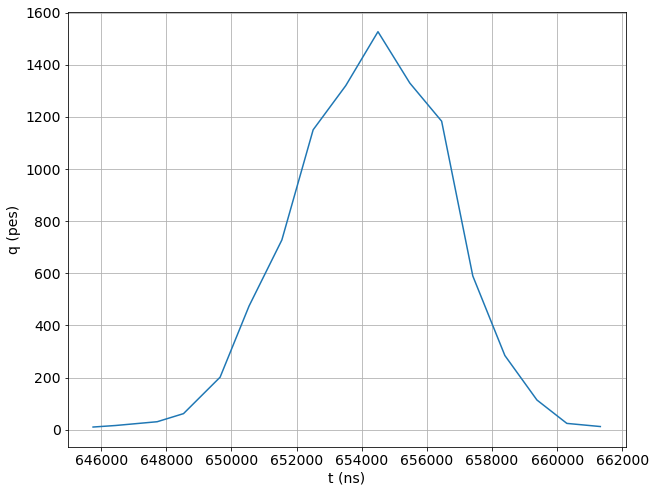

In [67]:
plot_S12(s2s)

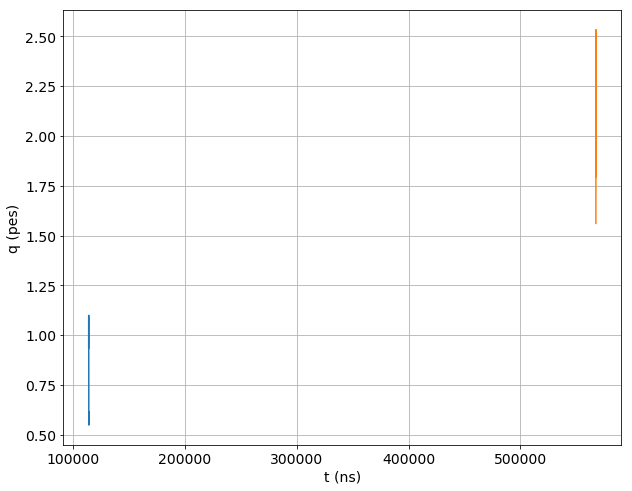

In [68]:
plot_S12(s1s)

In [69]:
kr_dst(s1s, s2s, xs, ys)

KrDst(es1=8.3215159338317584, ws1=75.0, es2=9060.2263565825997, ws2=75.0, qs2=54.495208321774975, dt=86.947656869593075, c=Cluster(Q=54.495208321774982, x=-109.97056928220188, y=-84.882277128807488, nsipm=2))

In [474]:
KR=[]
KR.append(kr_dst(s1s, s2s, xs, ys))

In [475]:
KR

[KrDst(es1=12.946851704767822, ws1=225.0, es2=13616.960710179161, ws2=225.0, qs2=334.37997549326423, dt=242.21323093507823, c=Cluster(Q=334.37997549326428, x=57.020926308669424, y=35.779696808250932, nsipm=7))]

### Event

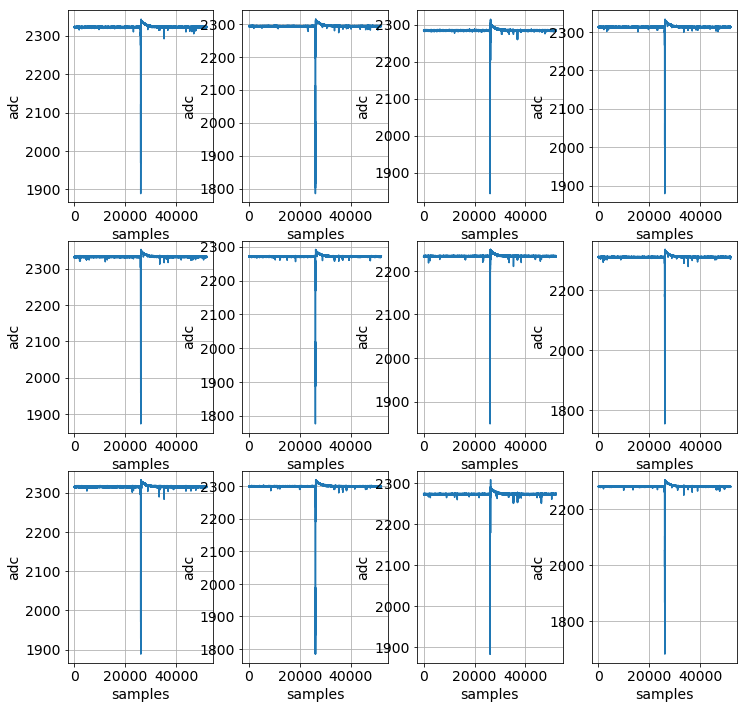

In [326]:
event=2
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

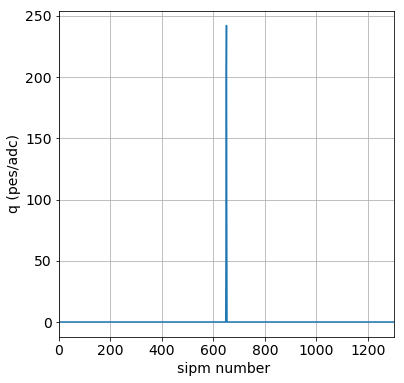

In [327]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=10,
                          bls_mode=csf.BlsMode.mode)
sipm_sums = np.sum(np.where(sipm_cal > 10, sipm_cal, 0), axis=0)
plot_sipm_signals_vs_time_mus(sipm_sums,
                              sipm_min =    0,
                              sipm_max =  2000)

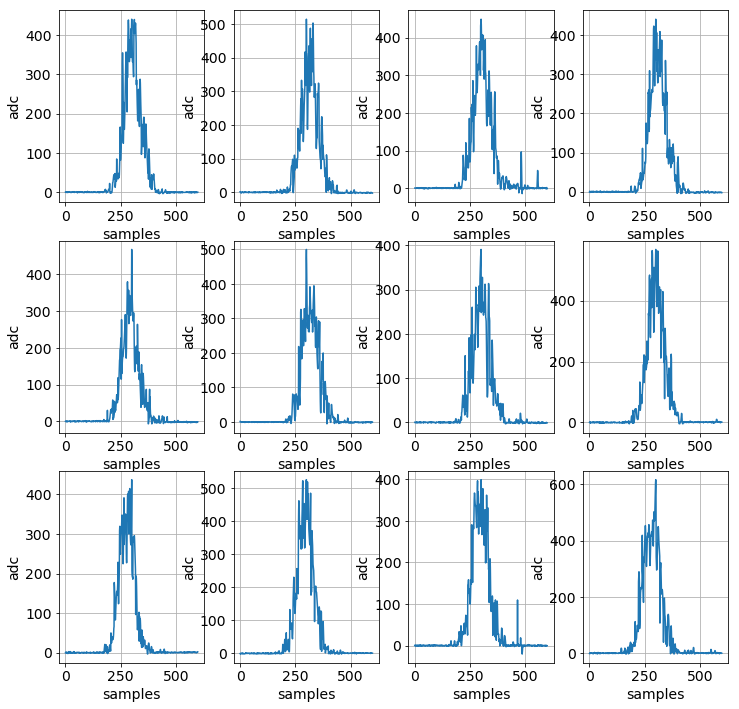

In [328]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

sf.plot_pmt_waveforms(CWF, zoom=True, window_size=300, figsize=(12,12))

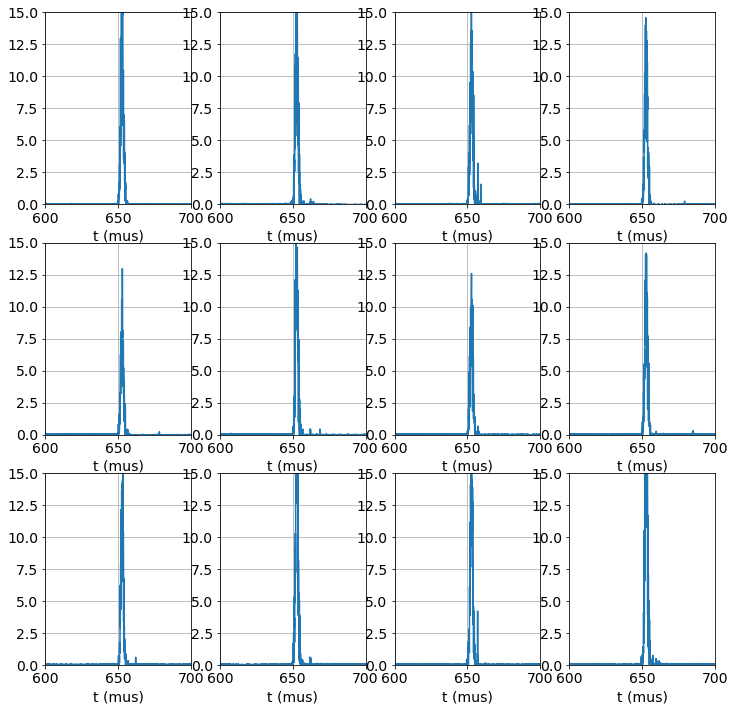

In [329]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)
plot_pmt_signals_vs_time_mus(ccwfs,
                                pmt_active,
                                t_min      =    600,
                                t_max      = 700,
                                signal_min =    0,
                                signal_max =  15,
                                 figsize=(12,12))

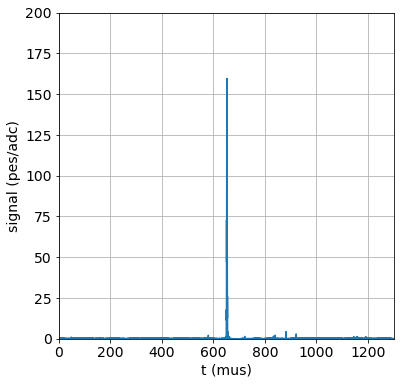

In [330]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  200,
                            figsize=(6,6))

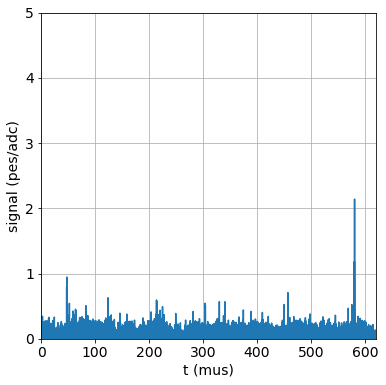

In [331]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 620,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [332]:
s1params = S12Params(time = minmax(min    = 120 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 7
 Times: [ 580.475  580.5    580.525  580.55   580.575  580.6    580.625] µs
 Time @ max energy: 580.525
 Width: 0.15 µs
 Height: 2.1406873572084 pes
 Energy: 8.482609348433959 pes
 Charge: 0.0 pes
 RMS: 0.04221407817342401 µs]

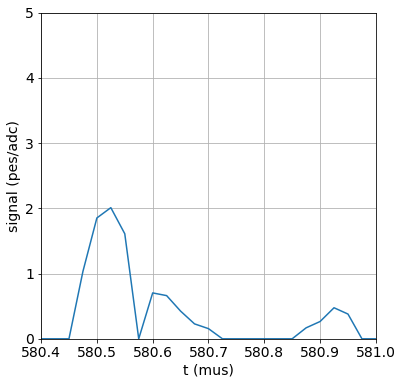

In [334]:
sf.plot_signal_vs_time_mus(cwf_sum_mau,
                            t_min      =580.4,
                            t_max      = 581,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

#### S1

- Signal at 47.7 has too little energy (closer to cathode should be larger in energy)
- Individual PMT information is very had to discern
- Signal at 580 is "peakier": Hieght of 2.14 pes tbc with < 1 pes for 47.7
- One can select s1 at 580 based in energy consistent with range and larger height. 

In [335]:
s2params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 800 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 9
       Times: [ 649.69652695  650.69145502  651.61885062  652.50629812  653.40794777
 654.33782041  655.25817752  656.67766065  657.23902966] µs
       Time @ max energy: 652.5062981151781
       Width: 7.542502706506639 µs
       Height: 5653.148671431077 pes
       Energy: 14011.332506536046 pes
       Charge: 574.1192721707315 pes
       RMS: 0.904665839111658 µs]

[[ 692]
 [ 694]
 [ 695]
 [1034]
 [1035]
 [1036]
 [1038]
 [1039]]


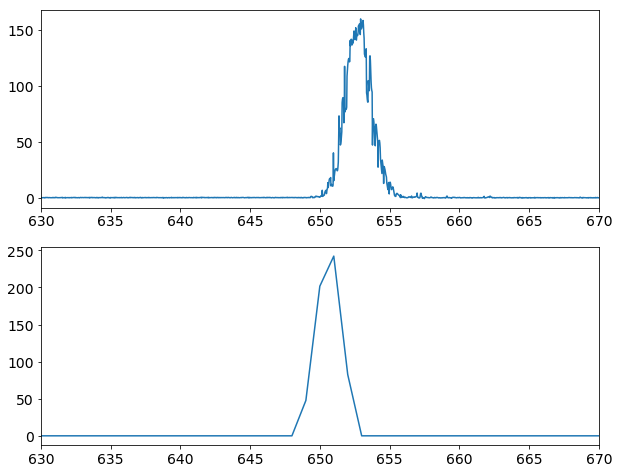

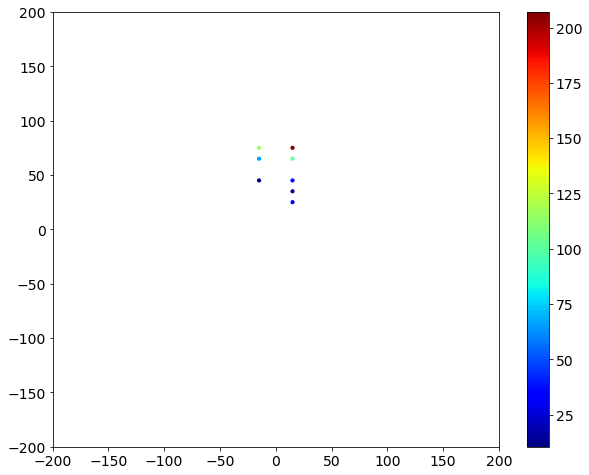

In [337]:
pmt_and_sipm(cwf_sum, sipm_cal, t_min=630, t_max=670)

#### S2
- Large S2 consistent with low drift. 

In [91]:
kr_dst(s1s, s2s, xs, ys)

KrDst(es1=7.0903624224555131, ws1=75.0, es2=14011.332506536046, ws2=75.0, qs2=987.96572930823038, dt=71.981298115178134, c=Cluster(Q=987.96572930823027, x=2.4305821891809565, y=48.438915090204411, nsipm=101))

### Event

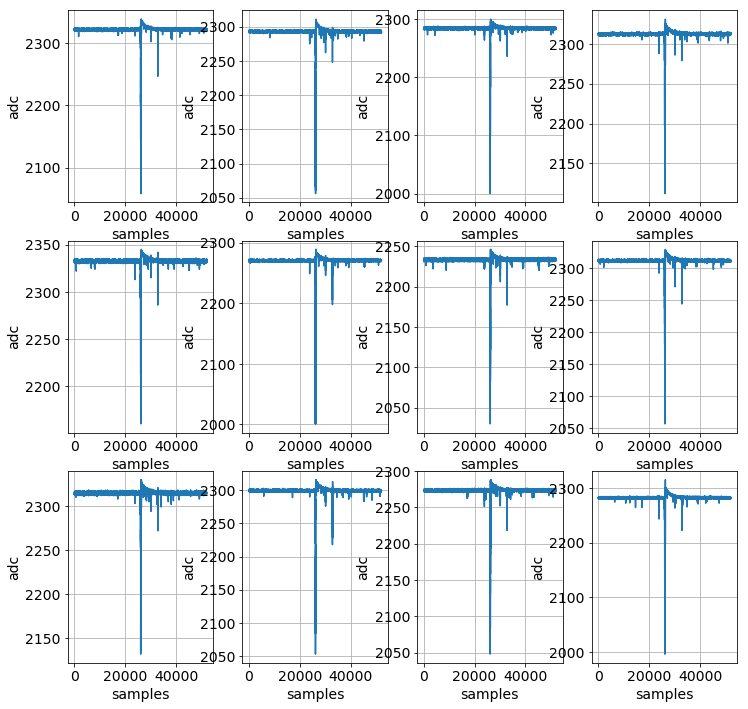

In [287]:
event=3
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

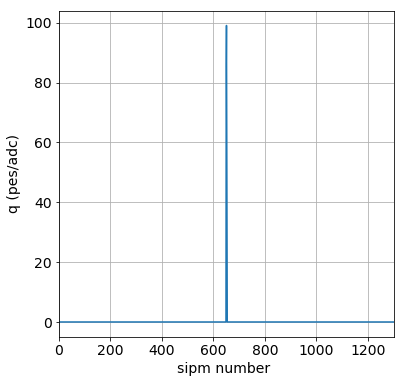

In [288]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=10,
                          bls_mode=csf.BlsMode.mode)
sipm_sums = np.sum(np.where(sipm_cal > 10, sipm_cal, 0), axis=0)
plot_sipm_signals_vs_time_mus(sipm_sums,
                              sipm_min =    0,
                              sipm_max =  2000)

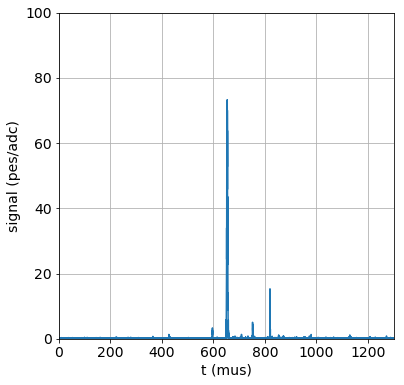

In [289]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

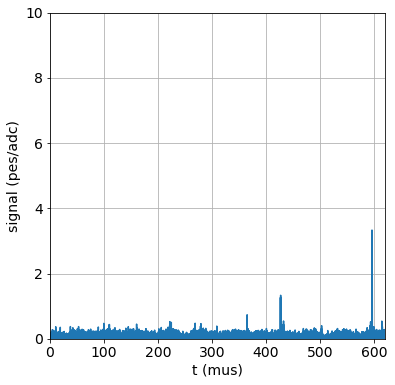

In [250]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 620,
                            signal_min =    0,
                            signal_max =  10,
                            figsize=(6,6))

In [251]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[]

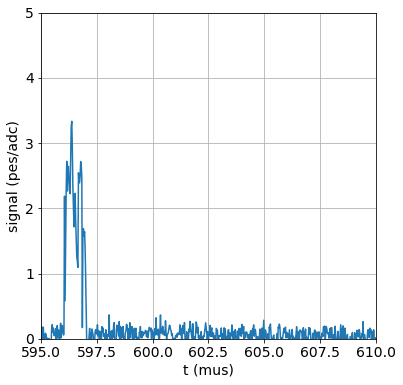

In [254]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =595,
                            t_max      = 610,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

- Not an S1

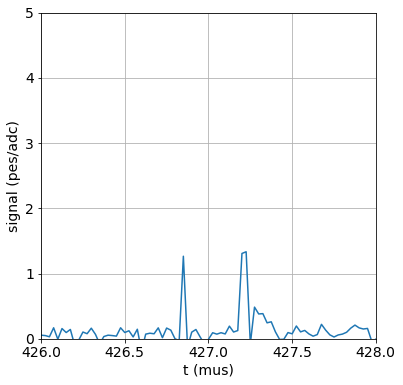

In [101]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =426,
                            t_max      = 428,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

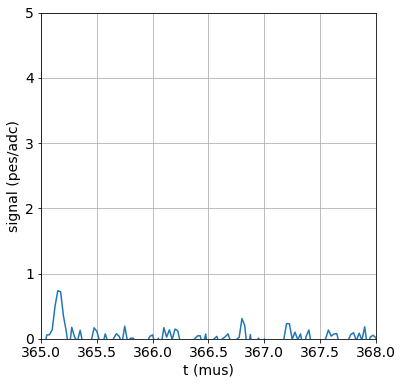

In [104]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =365,
                            t_max      = 368,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

#### No credible S1s

In [106]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 800 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 12
       Times: [ 648.89788053  649.61952188  650.59459646  651.5695628   652.52066688
 653.49343666  654.46081372  655.46113443  656.39619365  657.32331667
 658.32453947  659.        ] µs
       Time @ max energy: 653.4934366588985
       Width: 10.102119473671191 µs
       Height: 2499.1326729570264 pes
       Energy: 10710.600665162767 pes
       Charge: 710.456096756096 pes
       RMS: 1.5870369875787125 µs]

### Event

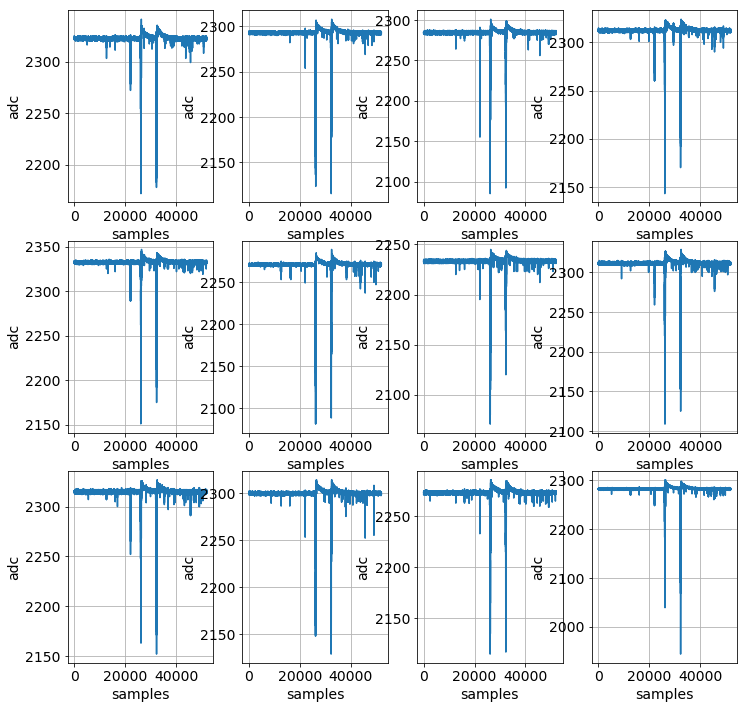

In [290]:
event=4
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

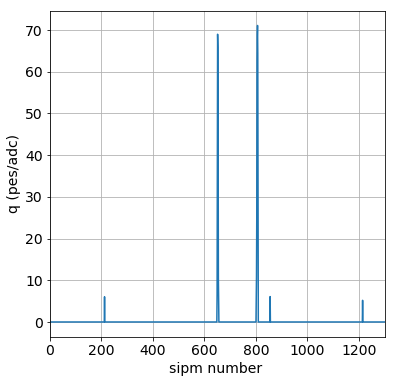

In [301]:
thr = 5
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=thr,
                          bls_mode=csf.BlsMode.mode)
sipm_sums = np.sum(np.where(sipm_cal > thr, sipm_cal, 0), axis=0)
plot_sipm_signals_vs_time_mus(sipm_sums,
                              sipm_min =    0,
                              sipm_max =  2000)

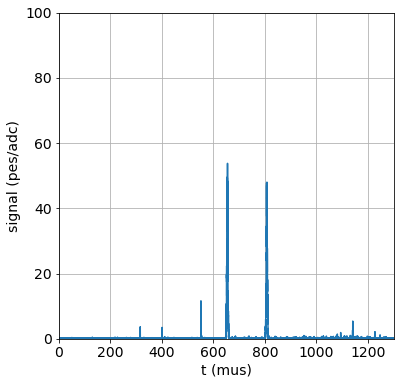

In [291]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

####  pileup

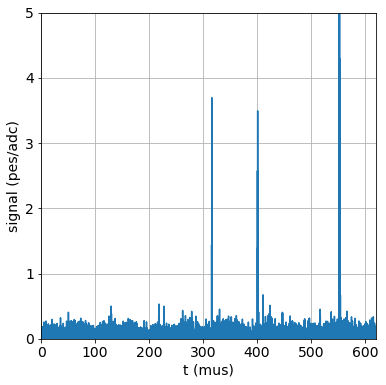

In [292]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 620,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

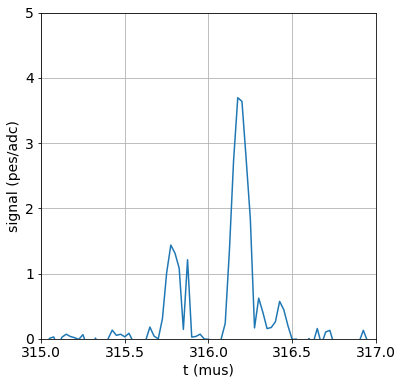

In [293]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =315,
                            t_max      = 317,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

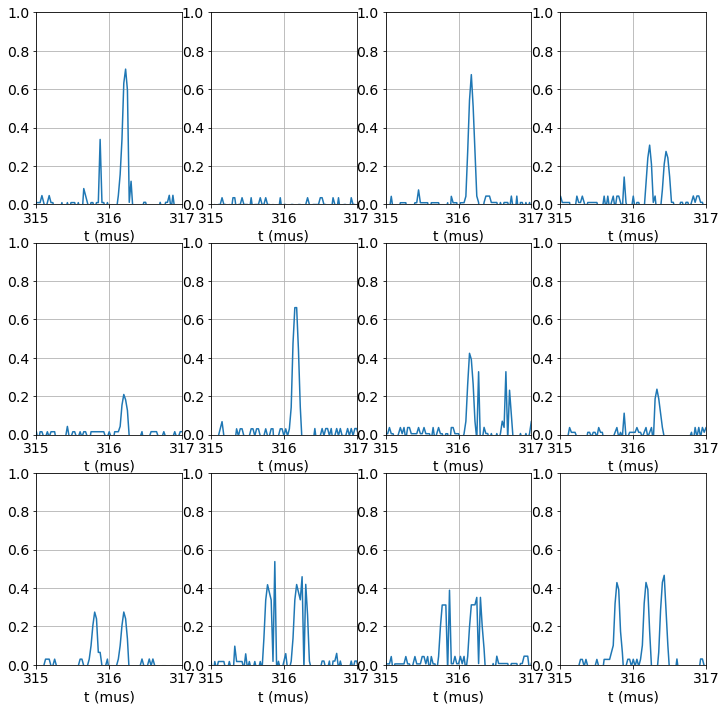

In [294]:
plot_pmt_signals_vs_time_mus(ccwfs,
                             pmt_active,
                            t_min      =315,
                            t_max      = 317,
                            signal_min =    0,
                            signal_max =  1,
                            figsize=(12,12))

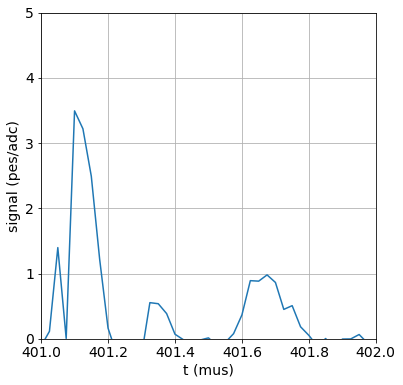

In [295]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =401,
                            t_max      = 402,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

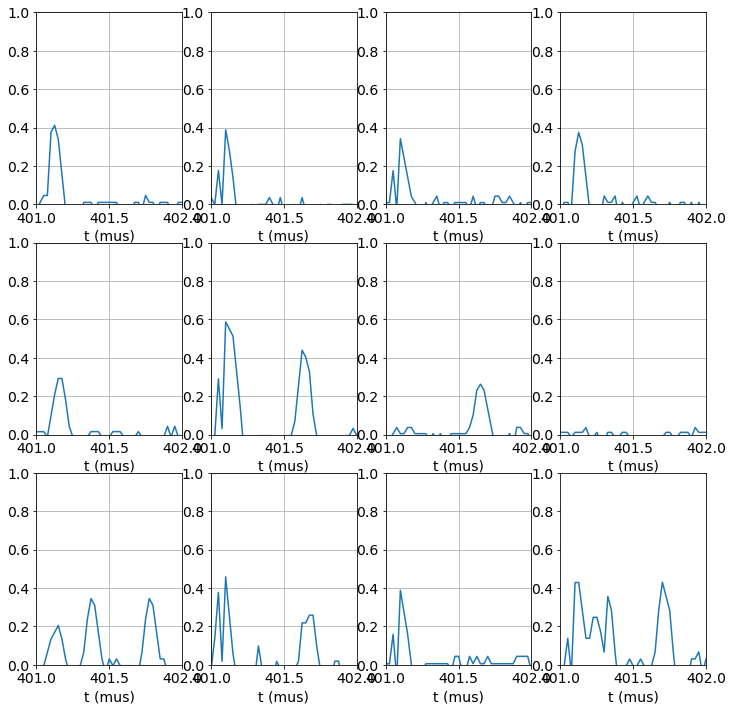

In [296]:
plot_pmt_signals_vs_time_mus(ccwfs,
                             pmt_active,
                            t_min      =401,
                            t_max      = 402,
                            signal_min =    0,
                            signal_max =  1,
                            figsize=(12,12))

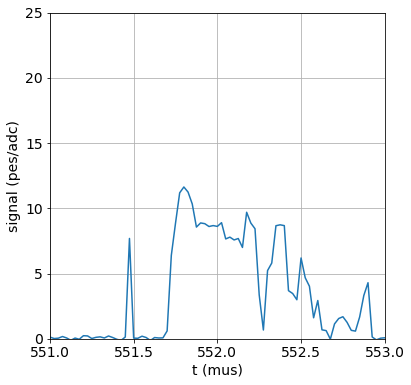

In [297]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =551,
                            t_max      = 553,
                            signal_min =    0,
                            signal_max =  25,
                            figsize=(6,6))

[]


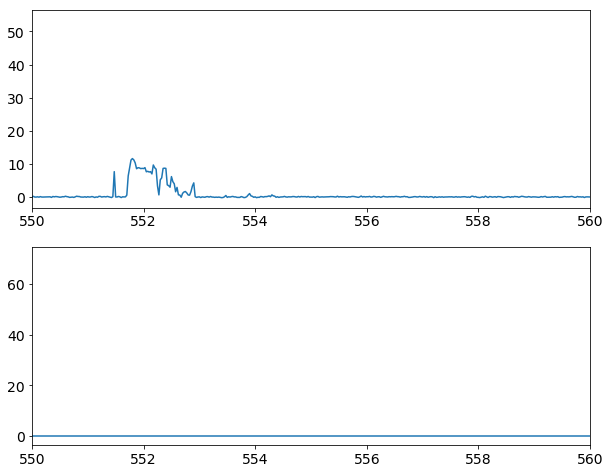

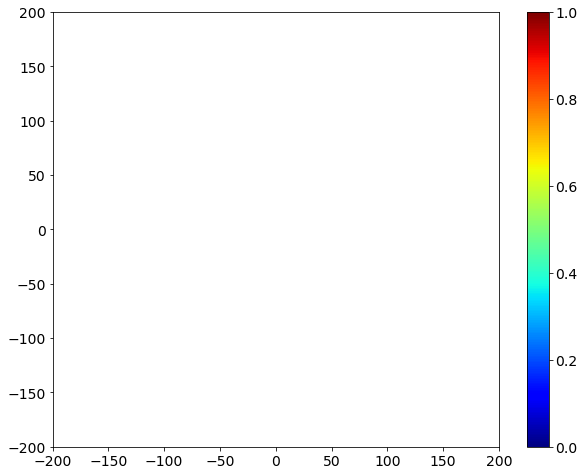

In [302]:
pmt_and_sipm(cwf_sum, sipm_cal, t_min=550, t_max=560)

In [110]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 6
 Times: [ 315.75   315.775  315.8    315.825  315.85   315.875] µs
 Time @ max energy: 315.775
 Width: 0.125 µs
 Height: 1.4366723211978927 pes
 Energy: 6.194679716991433 pes
 Charge: 0.0 pes
 RMS: 0.04219170410554005 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 14
       Times: [ 316.125  316.15   316.175  316.2    316.225  316.25   316.275  316.3
 316.325  316.35   316.375  316.4    316.425  316.45 ] µs
       Time @ max energy: 316.175
       Width: 0.325 µs
       Height: 3.6958798223122358 pes
       Energy: 18.826782662711807 pes
       Charge: 0.0 pes
       RMS: 0.07570001769553636 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 6
 Times: [ 401.05   401.075  401.1    401.125  401.15   401.175] µs
 Time @ max energy: 401.1
 Width: 0.125 µs
 Height: 3.4940582137763734 pes
 Energy: 11.828566889171244 p

In [118]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.75 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 6
 Times: [ 315.75   315.775  315.8    315.825  315.85   315.875] µs
 Time @ max energy: 315.775
 Width: 0.125 µs
 Height: 1.4366723211978927 pes
 Energy: 6.194679716991433 pes
 Charge: 0.0 pes
 RMS: 0.04219170410554005 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 8
 Times: [ 316.125  316.15   316.175  316.2    316.225  316.25   316.275  316.3  ] µs
 Time @ max energy: 316.175
 Width: 0.175 µs
 Height: 3.6958798223122358 pes
 Energy: 16.81043981319941 pes
 Charge: 0.0 pes
 RMS: 0.042035429575015014 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 6
 Times: [ 401.05   401.075  401.1    401.125  401.15   401.175] µs
 Time @ max energy: 401.1
 Width: 0.125 µs
 Height: 3.4940582137763734 pes
 Energy: 11.828566889171244 pes
 Charge: 0.0 pes
 RMS: 0.034722382318197124 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number 

In [123]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 800 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 13
       Times: [ 648.70012085  649.62755681  650.56298761  651.52167786  652.53248985
 653.49835632  654.48502985  655.44508901  656.44642598  657.42395798
 658.4094709   659.382086    660.13398435] µs
       Time @ max energy: 653.4983563216002
       Width: 11.43386350950494 µs
       Height: 1725.7917479664493 pes
       Energy: 8676.168816371992 pes
       Charge: 716.1146783909842 pes
       RMS: 1.9282627865014281 µs]

### Event

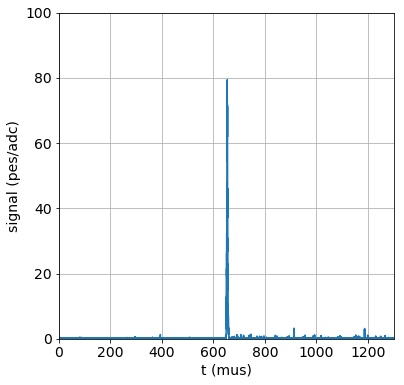

In [124]:
event=5
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

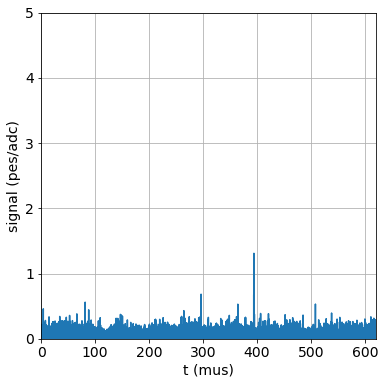

In [125]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 620,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

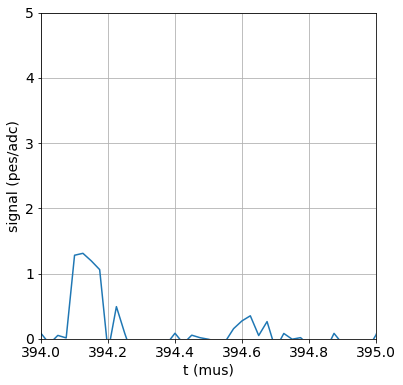

In [127]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =394,
                            t_max      = 395,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [126]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.75 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 4
 Times: [ 394.1    394.125  394.15   394.175] µs
 Time @ max energy: 394.125
 Width: 0.075 µs
 Height: 1.3103931134667959 pes
 Energy: 4.846317578153586 pes
 Charge: 0.0 pes
 RMS: 0.027498974558745684 µs]

In [128]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 800 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 11
       Times: [ 649.6651439   650.58879973  651.57290539  652.51156041  653.52657057
 654.48864955  655.44905835  656.42395169  657.39294253  658.37835294
 659.2418412 ] µs
       Time @ max energy: 654.4886495455015
       Width: 9.576697299727588 µs
       Height: 2737.5422254705063 pes
       Energy: 11338.297838084669 pes
       Charge: 689.9748330036429 pes
       RMS: 1.7008929154321455 µs]

In [129]:
kr_dst(s1s, s2s, xs, ys)

KrDst(es1=4.8463175781535863, ws1=75.0, es2=11338.297838084669, ws2=75.0, qs2=689.97483300364286, dt=260.36364954550157, c=Cluster(Q=689.97483300364286, x=-4.4334037985309598, y=113.56977762422268, nsipm=72))

### Event

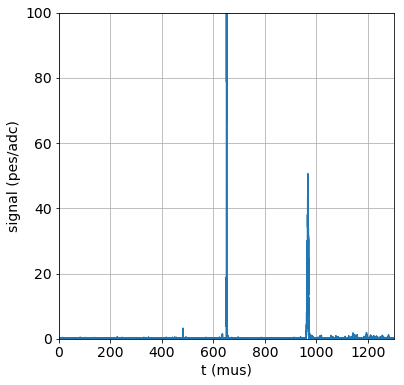

In [130]:
event=6
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

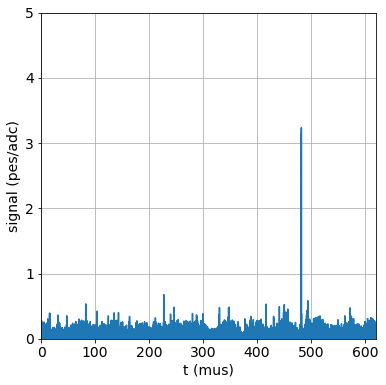

In [131]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 620,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

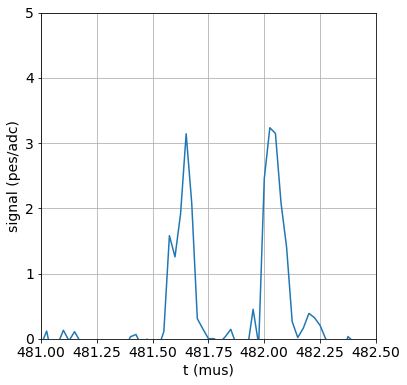

In [133]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =481,
                            t_max      = 482.5,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [132]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 481.575  481.6    481.625  481.65   481.675] µs
 Time @ max energy: 481.65
 Width: 0.1 µs
 Height: 3.142915233793709 pes
 Energy: 9.976510270046038 pes
 Charge: 0.0 pes
 RMS: 0.033772155151047936 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 482.     482.025  482.05   482.075  482.1  ] µs
 Time @ max energy: 482.025
 Width: 0.1 µs
 Height: 3.2355976636137305 pes
 Energy: 12.328308726929247 pes
 Charge: 0.0 pes
 RMS: 0.03176045922380383 µs]

In [134]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 700 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)


s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 6
       Times: [ 649.96683357  650.80414892  651.58561674  652.33783549  653.2881544
 654.3573462 ] µs
       Time @ max energy: 651.5856167431647
       Width: 4.390512627330958 µs
       Height: 6266.512024688059 pes
       Energy: 12323.97579849827 pes
       Charge: 683.5738720371135 pes
       RMS: 0.5086621675562913 µs]

In [135]:
kr_dst(s1s, s2s, xs, ys)

KrDst(es1=12.328308726929247, ws1=100.0, es2=12323.97579849827, ws2=100.0, qs2=683.57387203711346, dt=169.56061674316473, c=Cluster(Q=683.57387203711346, x=-3.7393645021499609, y=114.81489889586939, nsipm=69))

### Event

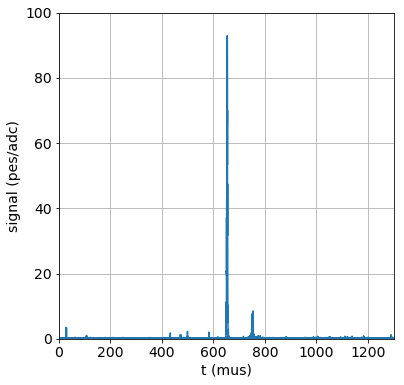

In [136]:
event=7
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

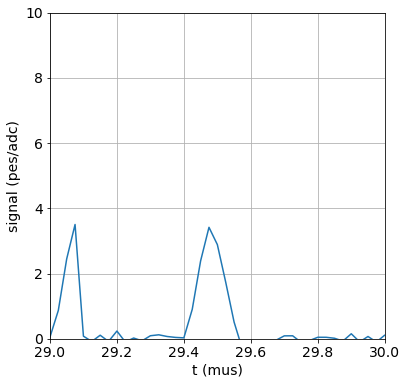

In [139]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =29,
                            t_max      = 30,
                            signal_min =    0,
                            signal_max =  10,
                            figsize=(6,6))

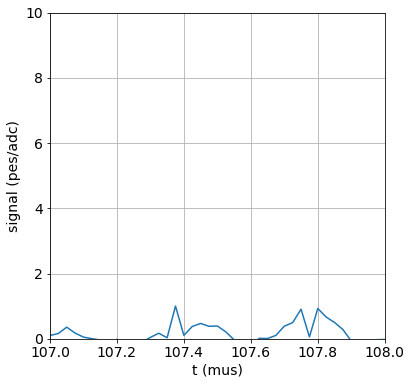

In [140]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =107,
                            t_max      = 108,
                            signal_min =    0,
                            signal_max =  10,
                            figsize=(6,6))

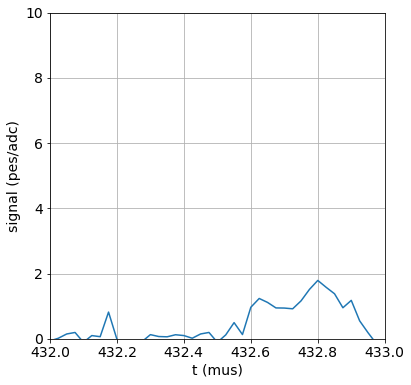

In [141]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =432,
                            t_max      = 433,
                            signal_min =    0,
                            signal_max =  10,
                            figsize=(6,6))

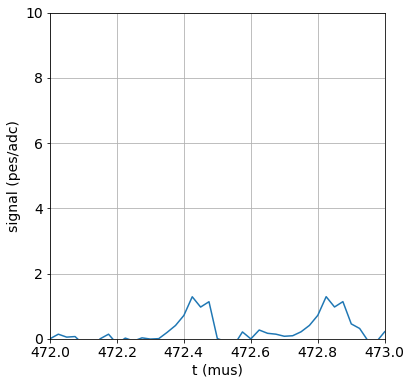

In [142]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =472,
                            t_max      = 473,
                            signal_min =    0,
                            signal_max =  10,
                            figsize=(6,6))

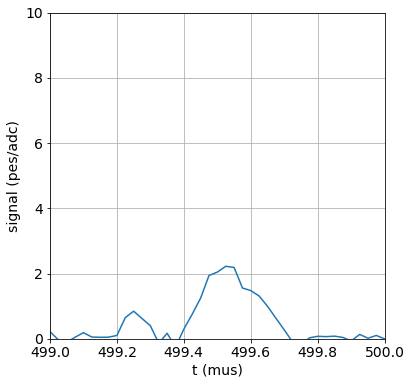

In [143]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =499,
                            t_max      = 500,
                            signal_min =    0,
                            signal_max =  10,
                            figsize=(6,6))

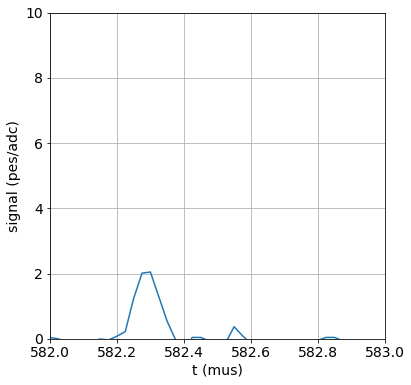

In [144]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =582,
                            t_max      = 583,
                            signal_min =    0,
                            signal_max =  10,
                            figsize=(6,6))

In [145]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 29.425  29.45   29.475  29.5    29.525] µs
 Time @ max energy: 29.475
 Width: 0.1 µs
 Height: 3.418054233029665 pes
 Energy: 11.332080958274384 pes
 Charge: 0.0 pes
 RMS: 0.029156890683699695 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 107.375  107.4    107.425  107.45   107.475] µs
 Time @ max energy: 107.375
 Width: 0.1 µs
 Height: 1.0030694333844836 pes
 Energy: 2.340235808181077 pes
 Charge: 0.0 pes
 RMS: 0.039342280360781204 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 4
 Times: [ 107.75   107.775  107.8    107.825] µs
 Time @ max energy: 107.8
 Width: 0.075 µs
 Height: 0.9283559307109052 pes
 Energy: 2.561008575088371 pes
 Charge: 0.0 pes
 RMS: 0.030410301275500425 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 15
       Times: [ 432.6    

In [146]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 700 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)


s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 10
       Times: [ 649.71671324  650.5767441   651.60631489  652.54927764  653.49803393
 654.43375555  655.39086715  656.41483407  657.42698528  658.23438321] µs
       Time @ max energy: 653.4980339325332
       Width: 8.517669967599678 µs
       Height: 3168.584386307547 pes
       Energy: 11294.081137291923 pes
       Charge: 687.9039352085399 pes
       RMS: 1.3424916635157875 µs]

### Event

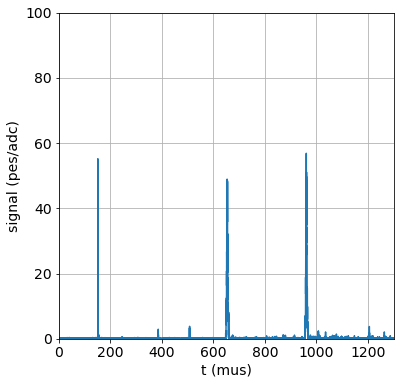

In [303]:
event=8
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

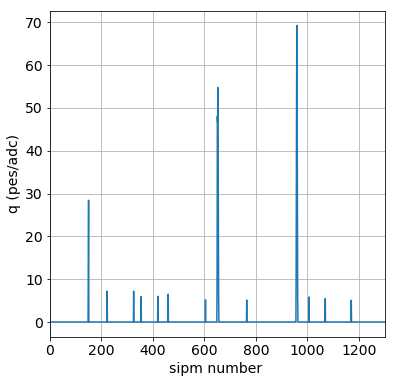

In [306]:
thr = 5
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=thr,
                          bls_mode=csf.BlsMode.mode)
sipm_sums = np.sum(np.where(sipm_cal > thr, sipm_cal, 0), axis=0)
plot_sipm_signals_vs_time_mus(sipm_sums)

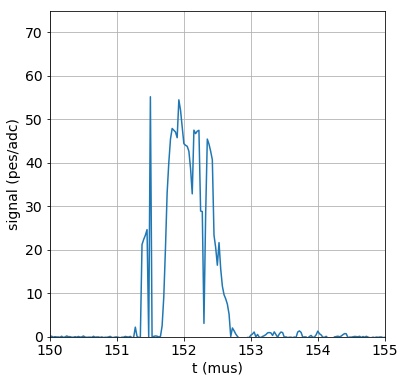

In [307]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =150,
                            t_max      = 155,
                            signal_min =    0,
                            signal_max =  75,
                            figsize=(6,6))

In [309]:
s1params = S12Params(time = minmax(min    = 150 * units.mus,
                                   max    = 155 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 2500),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 10
       Times: [ 151.275  151.3    151.325  151.35   151.375  151.4    151.425  151.45
 151.475  151.5  ] µs
       Time @ max energy: 151.5
       Width: 0.225 µs
       Height: 55.203102336241315 pes
       Energy: 149.14808841388287 pes
       Charge: 0.0 pes
       RMS: 0.051317938057133784 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 41
       Times: [ 151.675  151.7    151.725  151.75   151.775  151.8    151.825  151.85
 151.875  151.9    151.925  151.95   151.975  152.     152.025  152.05
 152.075  152.1    152.125  152.15   152.175  152.2    152.225  152.25
 152.275  152.3    152.325  152.35   152.375  152.4    152.425  152.45
 152.475  152.5    152.525  152.55   152.575  152.6    152.625  152.65
 152.675] µs
       Time @ max energy: 151.925
       Width: 1.0 µs
       Height: 54.49052445301901 pes
       Ener

[[612]
 [615]]


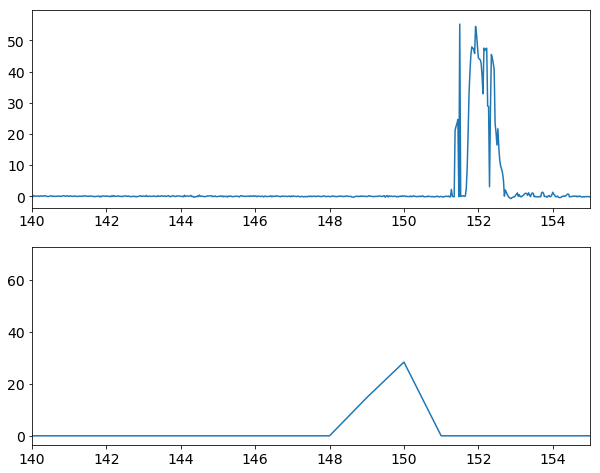

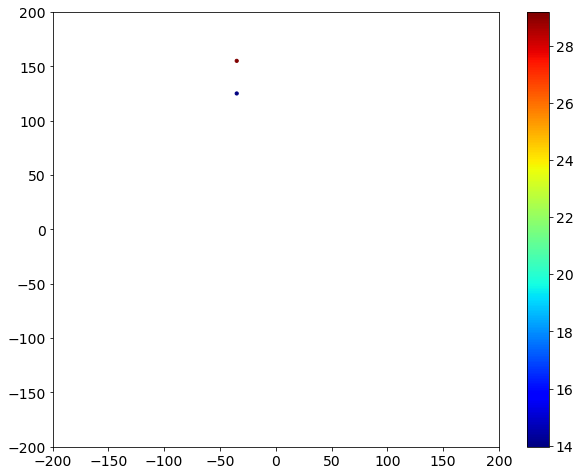

In [308]:
pmt_and_sipm(cwf_sum, sipm_cal, t_min=140, t_max=155)

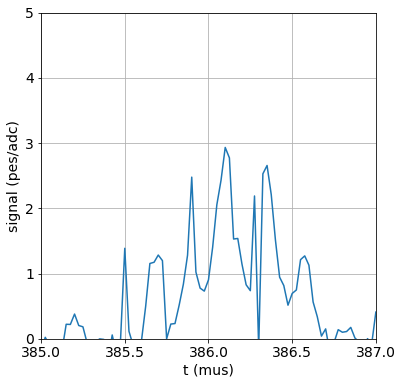

In [151]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =385,
                            t_max      = 387,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

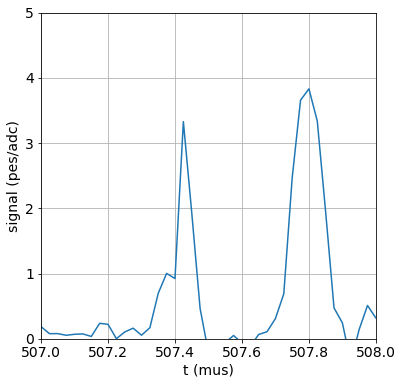

In [152]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =507,
                            t_max      = 508,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [148]:
s1params = S12Params(time = minmax(min    = 200 * units.mus,
                                   max    = 600 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 385.625  385.65   385.675  385.7    385.725] µs
 Time @ max energy: 385.7
 Width: 0.1 µs
 Height: 1.2838774450537938 pes
 Energy: 5.312230959874117 pes
 Charge: 0.0 pes
 RMS: 0.03218363031535712 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 6
 Times: [ 507.35   507.375  507.4    507.425  507.45   507.475] µs
 Time @ max energy: 507.425
 Width: 0.125 µs
 Height: 3.329038806001719 pes
 Energy: 8.354255756820049 pes
 Charge: 0.0 pes
 RMS: 0.03289060365821172 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 7
 Times: [ 507.725  507.75   507.775  507.8    507.825  507.85   507.875] µs
 Time @ max energy: 507.8
 Width: 0.15 µs
 Height: 3.832095208342149 pes
 Energy: 16.39992345512031 pes
 Charge: 0.0 pes
 RMS: 0.03644805391998583 µs]

In [154]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 1000 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)


s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 14
       Times: [ 647.9273196   648.48485971  649.58653284  650.5205247   651.53199201
 652.52037469  653.50965748  654.4997268   655.4501692   656.43877187
 657.44719373  658.41881403  659.33039116  660.55164921] µs
       Time @ max energy: 654.4997268037421
       Width: 12.624329610691872 µs
       Height: 1648.9975175284653 pes
       Energy: 8378.805604668285 pes
       Charge: 723.2727175750413 pes
       RMS: 2.1220372434485935 µs, 
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 14
       Times: [ 955.5119219   956.58202887  957.52173901  958.56730548  959.503192
 960.51848685  961.4771409   962.47569513  963.4562552   964.436043
 965.44633618  966.41148418  967.37605926  968.37670897] µs
       Time @ max energy: 961.477140904324
       Width: 12.864787063408178 µs
       Height: 1873.8823777391003 pes
       Energy: 

### Event

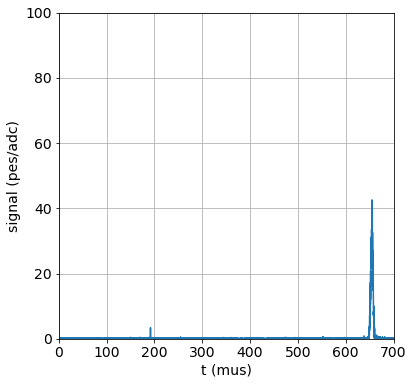

In [314]:
event=9
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

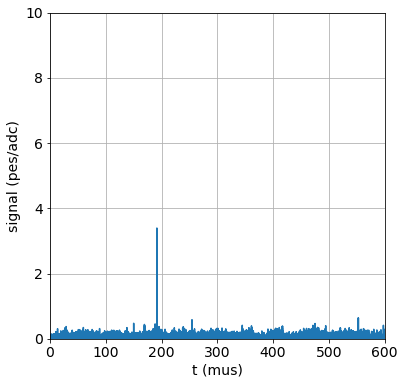

In [315]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 600,
                            signal_min =    0,
                            signal_max =  10,
                            figsize=(6,6))

In [316]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 7
 Times: [ 191.575  191.6    191.625  191.65   191.675  191.7    191.725] µs
 Time @ max energy: 191.625
 Width: 0.15 µs
 Height: 3.396095113291457 pes
 Energy: 14.828377855098767 pes
 Charge: 0.0 pes
 RMS: 0.03865434403093295 µs]

In [317]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 700 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)


s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 13
       Times: [ 648.68736353  649.57156743  650.59378949  651.53641225  652.52005697
 653.48744785  654.51938612  655.46878959  656.45427271  657.42132667
 658.44865016  659.46823589  660.1923807 ] µs
       Time @ max energy: 654.5193861201642
       Width: 11.50501717938413 µs
       Height: 1295.7596282393583 pes
       Energy: 7328.842351496809 pes
       Charge: 233.71900293800746 pes
       RMS: 2.1959111110074545 µs]

### Event

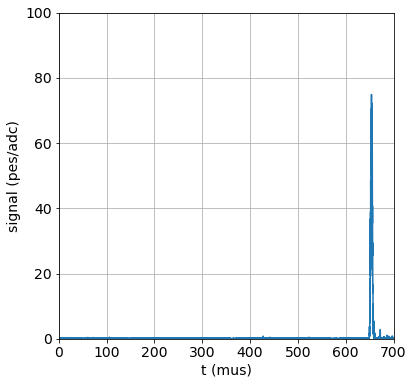

In [318]:
event=10
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

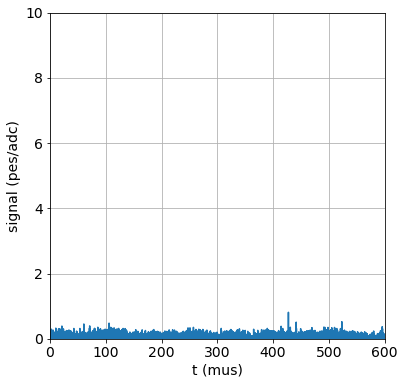

In [320]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 600,
                            signal_min =    0,
                            signal_max =  10,
                            figsize=(6,6))

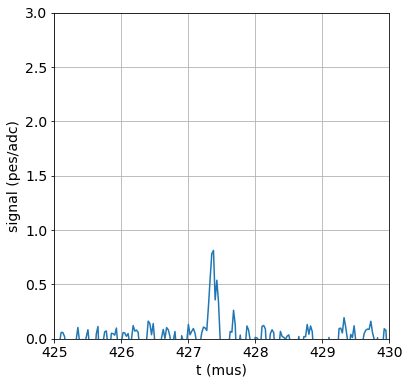

In [323]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =425,
                            t_max      = 430,
                            signal_min =    0,
                            signal_max =  3,
                            figsize=(6,6))

In [321]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[]

In [324]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 700 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)


s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 11
       Times: [ 649.70793541  650.58759787  651.57931373  652.51221049  653.5011271
 654.4822379   655.42847006  656.40135492  657.39927521  658.45134129
 659.12126468] µs
       Time @ max energy: 654.4822379000016
       Width: 9.413329272502567 µs
       Height: 2552.543964421443 pes
       Energy: 11576.122030428849 pes
       Charge: 233.71900293800746 pes
       RMS: 1.604928871857787 µs]

### Event

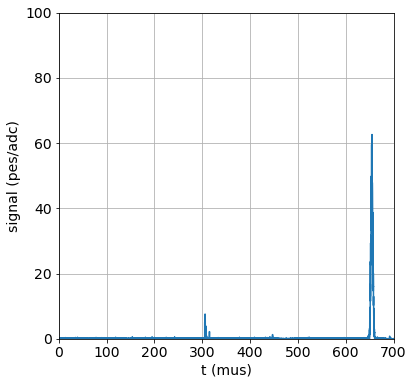

In [310]:
event=11
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

### Event

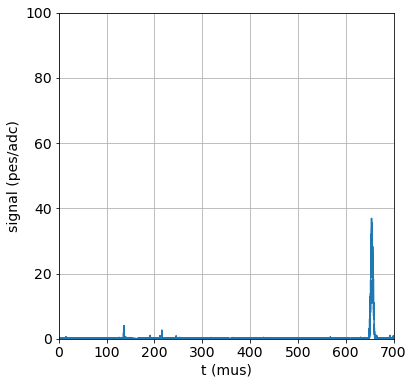

In [311]:
event=12
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

In [553]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 124.275  124.3    124.325  124.35   124.375] µs
 Time @ max energy: 124.325
 Width: 0.1 µs
 Height: 0.9838244042946815 pes
 Energy: 3.9646728693136555 pes
 Charge: 0.0 pes
 RMS: 0.03259654681619863 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 13
       Times: [ 164.1    164.125  164.15   164.175  164.2    164.225  164.25   164.275
 164.3    164.325  164.35   164.375  164.4  ] µs
       Time @ max energy: 164.125
       Width: 0.3 µs
       Height: 1.7555179098913445 pes
       Energy: 12.93653402810806 pes
       Charge: 0.0 pes
       RMS: 0.09328017816439567 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 4
 Times: [ 340.45   340.475  340.5    340.525] µs
 Time @ max energy: 340.5
 Width: 0.075 µs
 Height: 1.2551143516917507 pes
 Energy: 4.216917087283813 pes
 Charge: 0.0 pes
 RMS: 0.02594077963

In [554]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 700 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)


s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 15
       Times: [ 647.88045839  648.53931732  649.60010952  650.55810863  651.55080335
 652.55467411  653.47507674  654.47364165  655.46549302  656.4812828
 657.4501622   658.34796012  659.44538713  660.38886792  661.15683429] µs
       Time @ max energy: 654.473641652347
       Width: 13.276375902561703 µs
       Height: 1993.9724311004024 pes
       Energy: 10753.214430995924 pes
       Charge: 764.2078722836386 pes
       RMS: 2.1267870104800726 µs]

In [555]:
KR.append(kr_dst(s1s, s2s, xs, ys))
KR

[KrDst(es1=12.946851704767822, ws1=225.0, es2=13616.960710179161, ws2=225.0, qs2=334.37997549326423, dt=242.21323093507823, c=Cluster(Q=334.37997549326428, x=57.020926308669424, y=35.779696808250932, nsipm=7)),
 KrDst(es1=24.632143180461561, ws1=550.0, es2=12732.169696089704, ws2=550.0, qs2=806.98207636866016, dt=550.40813448112203, c=Cluster(Q=806.98207636866016, x=-20.280406837189968, y=53.111025479487076, nsipm=83)),
 KrDst(es1=4.2922641698837651, ws1=100.0, es2=8267.5100749920839, ws2=100.0, qs2=476.12195218014847, dt=348.9192680998305, c=Cluster(Q=476.12195218014841, x=35.619749348227387, y=96.227390320957241, nsipm=65)),
 KrDst(es1=14.326128761767084, ws1=225.0, es2=9957.6714959838191, ws2=225.0, qs2=745.6633791330878, dt=164.61142953873204, c=Cluster(Q=745.66337913308757, x=32.983391130106178, y=-180.43350651934065, nsipm=78)),
 KrDst(es1=33.509276513120163, ws1=525.0, es2=6930.0293127460127, ws2=525.0, qs2=764.20787228363861, dt=497.84401588461151, c=Cluster(Q=764.2078722836386

### Event

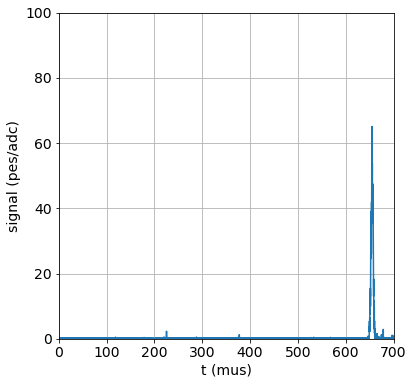

In [556]:
event=13
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

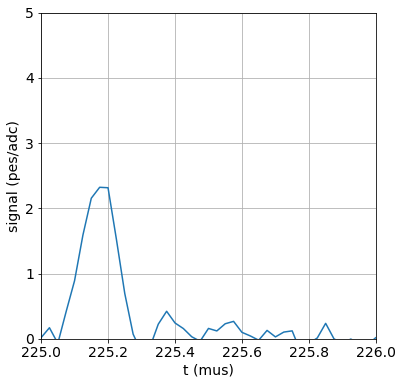

In [560]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =225,
                            t_max      = 226,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

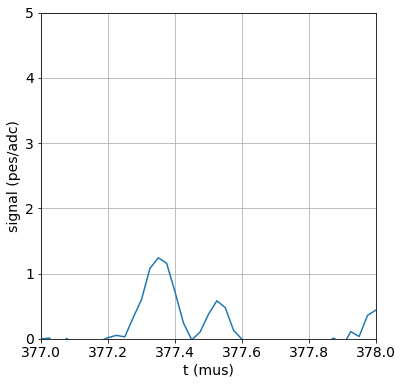

In [561]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =377,
                            t_max      = 378,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [562]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.75 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 6
 Times: [ 225.1    225.125  225.15   225.175  225.2    225.225] µs
 Time @ max energy: 225.175
 Width: 0.125 µs
 Height: 2.322643332041664 pes
 Energy: 10.799359622813228 pes
 Charge: 0.0 pes
 RMS: 0.03750134341313156 µs]

In [563]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 700 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)


s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 14
       Times: [ 649.60454021  650.55225075  651.52874092  652.53673985  653.5074358
 654.51750714  655.45479607  656.47200448  657.43035381  658.43059312
 659.40890675  660.35463662  661.39922723  662.03115744] µs
       Time @ max energy: 654.5175071392075
       Width: 12.426617229769356 µs
       Height: 2165.0372697291186 pes
       Energy: 11494.623191808274 pes
       Charge: 753.2493623435839 pes
       RMS: 2.1506459222845464 µs]

In [564]:
KR.append(kr_dst(s1s, s2s, xs, ys))
KR

[KrDst(es1=12.946851704767822, ws1=225.0, es2=13616.960710179161, ws2=225.0, qs2=334.37997549326423, dt=242.21323093507823, c=Cluster(Q=334.37997549326428, x=57.020926308669424, y=35.779696808250932, nsipm=7)),
 KrDst(es1=24.632143180461561, ws1=550.0, es2=12732.169696089704, ws2=550.0, qs2=806.98207636866016, dt=550.40813448112203, c=Cluster(Q=806.98207636866016, x=-20.280406837189968, y=53.111025479487076, nsipm=83)),
 KrDst(es1=4.2922641698837651, ws1=100.0, es2=8267.5100749920839, ws2=100.0, qs2=476.12195218014847, dt=348.9192680998305, c=Cluster(Q=476.12195218014841, x=35.619749348227387, y=96.227390320957241, nsipm=65)),
 KrDst(es1=14.326128761767084, ws1=225.0, es2=9957.6714959838191, ws2=225.0, qs2=745.6633791330878, dt=164.61142953873204, c=Cluster(Q=745.66337913308757, x=32.983391130106178, y=-180.43350651934065, nsipm=78)),
 KrDst(es1=33.509276513120163, ws1=525.0, es2=6930.0293127460127, ws2=525.0, qs2=764.20787228363861, dt=497.84401588461151, c=Cluster(Q=764.2078722836386

### Event

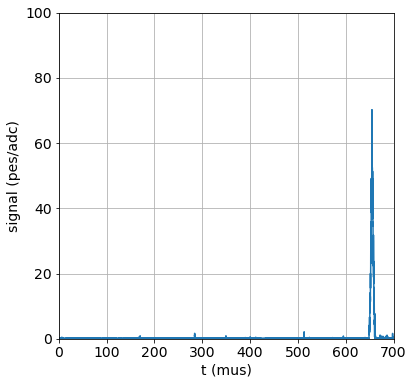

In [565]:
event=14
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

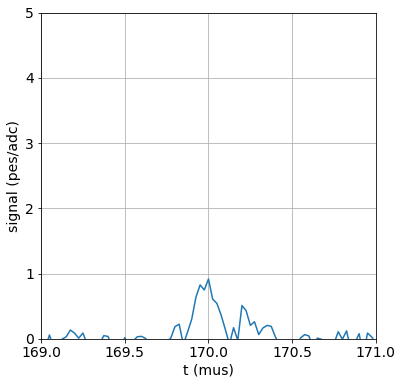

In [568]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =169,
                            t_max      = 171,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

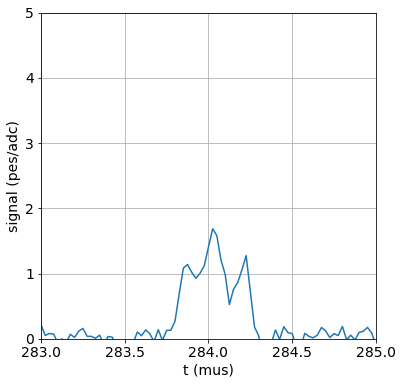

In [569]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =283,
                            t_max      = 285,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

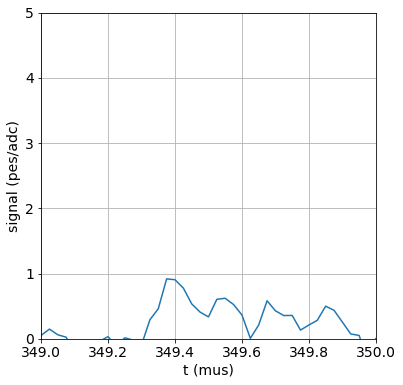

In [570]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =349,
                            t_max      = 350,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

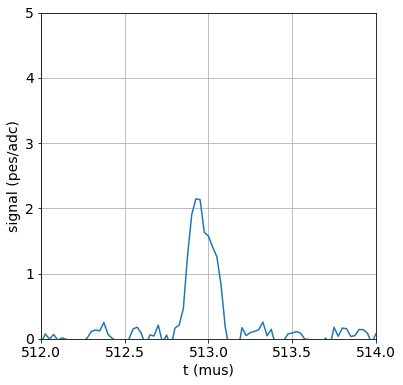

In [571]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =512,
                            t_max      = 514,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

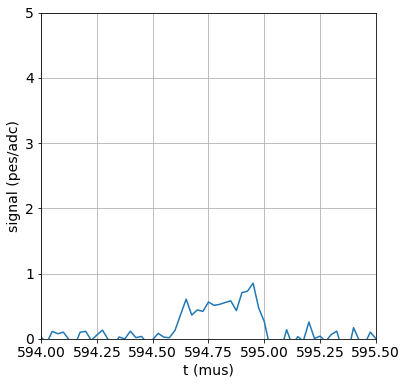

In [573]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =594,
                            t_max      = 595.5,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [574]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 700 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)


s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 14
       Times: [ 648.7710672   649.51547401  650.54878203  651.53823152  652.49397391
 653.50978406  654.508531    655.47879022  656.45790057  657.46904375
 658.4059704   659.40338732  660.4826455   661.18755798] µs
       Time @ max energy: 654.508531003797
       Width: 12.416490777133149 µs
       Height: 2067.7087522390348 pes
       Energy: 11605.516915369819 pes
       Charge: 760.8614535951772 pes
       RMS: 2.2831163696671806 µs]

In [575]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.75 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 17
       Times: [ 283.85   283.875  283.9    283.925  283.95   283.975  284.     284.025
 284.05   284.075  284.1    284.125  284.15   284.175  284.2    284.225
 284.25 ] µs
       Time @ max energy: 284.025
       Width: 0.4 µs
       Height: 1.6869568719433432 pes
       Energy: 18.374195367038215 pes
       Charge: 0.0 pes
       RMS: 0.11771628848397205 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 8
 Times: [ 512.875  512.9    512.925  512.95   512.975  513.     513.025  513.05 ] µs
 Time @ max energy: 512.925
 Width: 0.175 µs
 Height: 2.14660611845839 pes
 Energy: 13.329889582497557 pes
 Charge: 0.0 pes
 RMS: 0.05330858758585486 µs]

In [576]:
KR.append(kr_dst(s1s, s2s, xs, ys))
KR

[KrDst(es1=12.946851704767822, ws1=225.0, es2=13616.960710179161, ws2=225.0, qs2=334.37997549326423, dt=242.21323093507823, c=Cluster(Q=334.37997549326428, x=57.020926308669424, y=35.779696808250932, nsipm=7)),
 KrDst(es1=24.632143180461561, ws1=550.0, es2=12732.169696089704, ws2=550.0, qs2=806.98207636866016, dt=550.40813448112203, c=Cluster(Q=806.98207636866016, x=-20.280406837189968, y=53.111025479487076, nsipm=83)),
 KrDst(es1=4.2922641698837651, ws1=100.0, es2=8267.5100749920839, ws2=100.0, qs2=476.12195218014847, dt=348.9192680998305, c=Cluster(Q=476.12195218014841, x=35.619749348227387, y=96.227390320957241, nsipm=65)),
 KrDst(es1=14.326128761767084, ws1=225.0, es2=9957.6714959838191, ws2=225.0, qs2=745.6633791330878, dt=164.61142953873204, c=Cluster(Q=745.66337913308757, x=32.983391130106178, y=-180.43350651934065, nsipm=78)),
 KrDst(es1=33.509276513120163, ws1=525.0, es2=6930.0293127460127, ws2=525.0, qs2=764.20787228363861, dt=497.84401588461151, c=Cluster(Q=764.2078722836386

### Event

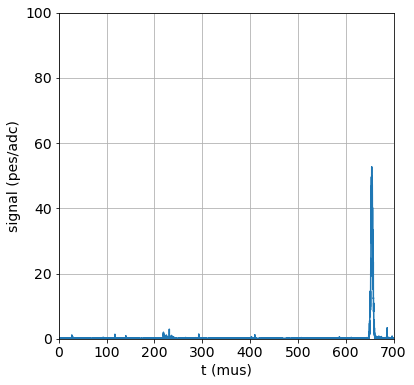

In [577]:
event=15
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

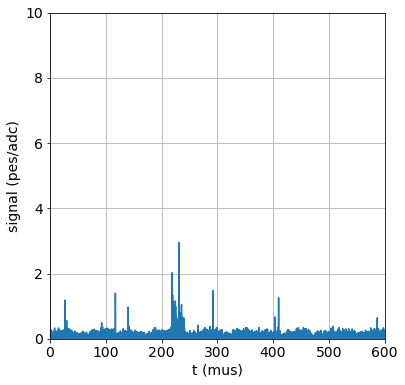

In [579]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 600,
                            signal_min =    0,
                            signal_max =  10,
                            figsize=(6,6))

In [580]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.75 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 4
 Times: [ 27.1    27.125  27.15   27.175] µs
 Time @ max energy: 27.15
 Width: 0.075 µs
 Height: 1.186333240280328 pes
 Energy: 4.155896843886839 pes
 Charge: 0.0 pes
 RMS: 0.02724246369800994 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 8
 Times: [ 117.2    117.225  117.25   117.275  117.3    117.325  117.35   117.375] µs
 Time @ max energy: 117.225
 Width: 0.175 µs
 Height: 1.401433081074158 pes
 Energy: 8.362406455843303 pes
 Charge: 0.0 pes
 RMS: 0.05538004511574037 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 7
 Times: [ 139.975  140.     140.025  140.05   140.075  140.1    140.125] µs
 Time @ max energy: 140.0
 Width: 0.15 µs
 Height: 0.9689863703001973 pes
 Energy: 5.692245000515783 pes
 Charge: 0.0 pes
 RMS: 0.050163508248723905 µs, 
       ---------------------
       S1 instance
       ---------------------
       Num

### Event

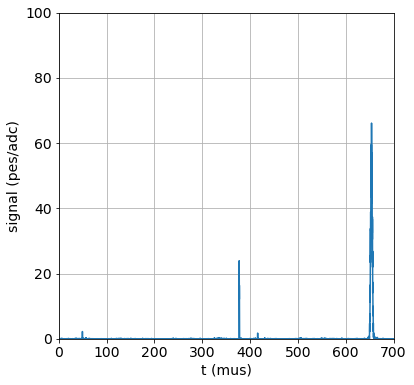

In [581]:
event=16
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

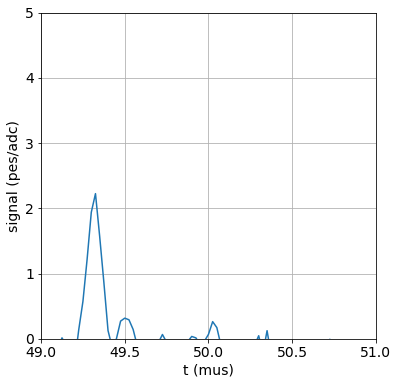

In [586]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =49,
                            t_max      = 51,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

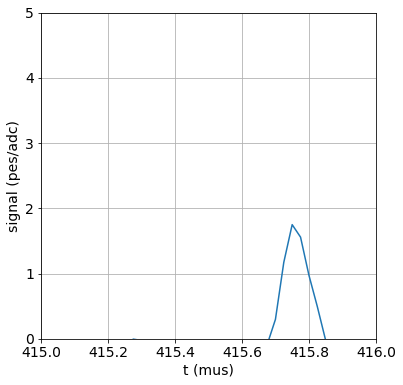

In [587]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =415,
                            t_max      = 416,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [584]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.75 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 49.275  49.3    49.325  49.35   49.375] µs
 Time @ max energy: 49.325
 Width: 0.1 µs
 Height: 2.225344646059359 pes
 Energy: 7.823950448974819 pes
 Charge: 0.0 pes
 RMS: 0.030590760732443063 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 4
 Times: [ 415.725  415.75   415.775  415.8  ] µs
 Time @ max energy: 415.75
 Width: 0.075 µs
 Height: 1.750000843882254 pes
 Energy: 5.457043016224121 pes
 Charge: 0.0 pes
 RMS: 0.025399548582814374 µs]

In [583]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 700 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)


s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 10
       Times: [ 649.80265502  650.60391892  651.56321193  652.5266907   653.49973665
 654.47011036  655.43302567  656.40155574  657.31623356  658.28199549] µs
       Time @ max energy: 653.4997366455733
       Width: 8.479340469887829 µs
       Height: 2206.2455433945415 pes
       Energy: 9537.373553609616 pes
       Charge: 745.6633791330878 pes
       RMS: 1.583134399067182 µs]

### Conclusions

- Deconvolution correct
- Not clear how to select S1
- Not clear dependence of S1 light with Z
- Need to try selection including PMT counting. 
- Need to try selection on "peaky stuff" as opposed to "flat stuff"